## Подготовка

### Импорт библиотек

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
from matplotlib.pyplot import rcParams
import seaborn as sns
import py7zr
rcParams['figure.figsize'] = 16, 8
dn = os.path.dirname

### Константы

In [3]:
# GBQ constants
GCP_PROJECT = os.environ.get('GCP_PROJECT', 'raifhack-326722')
EXPORT_MODE = os.environ.get('EXPORT_MODE', 'fail') # could be replace or fail or append  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_gbq.html
DATASET = 'raw_data'

# Determine directories
CURRENT_DIR = os. getcwd()
BASE_DIR = dn(dn(dn(CURRENT_DIR))) + '\\' # here number of dn(dn(x)) should be changed based on where script is located
DATA_DIR = BASE_DIR + 'data\\'
MODELS_DIR = BASE_DIR + 'models\\'
EXTERNAL_DATA_DIR = DATA_DIR + 'external\\'
RAW_DATA_DIR = DATA_DIR + 'raw\\'
INTERMEDIATE_DATA_DIR = DATA_DIR + 'intermediate\\'
FINAL_DATA_DIR = DATA_DIR + 'final\\'

print(f'CURRENT_DIR = {CURRENT_DIR}')
print(f'BASE_DIR = {BASE_DIR}')
print(f'MODELS_DIR = {MODELS_DIR}')
print(f'DATA_DIR = {DATA_DIR}')
print(f'RAW_DATA_DIR = {RAW_DATA_DIR}')
print(f'EXTERNAL_DATA_DIR = {EXTERNAL_DATA_DIR}')
print(f'INTERMEDIATE_DATA_DIR = {INTERMEDIATE_DATA_DIR}')
print(f'FINAL_DATA_DIR = {FINAL_DATA_DIR}')

# Feature Constants
TV = 'per_square_meter_price'

CURRENT_DIR = c:\Users\steel\github\raifhack_ds
BASE_DIR = c:\Users\
MODELS_DIR = c:\Users\models\
DATA_DIR = c:\Users\data\
RAW_DATA_DIR = c:\Users\data\raw\
EXTERNAL_DATA_DIR = c:\Users\data\external\
INTERMEDIATE_DATA_DIR = c:\Users\data\intermediate\
FINAL_DATA_DIR = c:\Users\data\final\


## Уменьшение памяти

In [9]:
def reduce_mem_usage (df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == "float":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == "int":
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo("i1").min and c_max < np.iinfo("i1").max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo("i2").min and c_max < np.iinfo("i2").max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo("i4").min and c_max < np.iinfo("i4").max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo("i8").min and c_max < np.iinfo("i8").max:
                df[col] = df[col].astype(np.int64)
        elif col == "timestamp":
            df[col] = pd.to_datetime(df[col])
        elif str(col_type)[:8] != "datetime":
            df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory consumption reduced', round(start_mem - end_mem, 2), 'Mb (minus', round(100 * (start_mem - end_mem) / start_mem, 1), '%)')
    return df

archive = py7zr.SevenZipFile('data/raw/data.7z', mode='r')
archive.extractall(path="data/raw")
archive.close()
train = pd.read_csv ('data/raw/data/train.csv')
test = pd.read_csv('data/raw/data/test.csv')
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

C:\Users\steel\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Memory consumption reduced 118.61 Mb (minus 72.2 %)
Memory consumption reduced 1.25 Mb (minus 72.8 %)


### Базовая обработка фич

In [10]:
dfs = {"train": train, "test": test}

for name, df in dfs.items():
    df["price_type"] = df["price_type"].astype('category')
    df["realty_type"] = df["realty_type"].astype('category')

In [11]:
quantitative = [f for f in train.columns if train.dtypes[f].name != 'category']
quantitative.remove('lat')
quantitative.remove('lng')
quantitative.remove('per_square_meter_price')
qualitative = [f for f in train.columns if train.dtypes[f].name == 'category']
qualitative.remove('id')

In [12]:
print(qualitative)
print(quantitative)

['city', 'floor', 'osm_city_nearest_name', 'region', 'street', 'date', 'realty_type', 'price_type']
['osm_amenity_points_in_0.001', 'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075', 'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001', 'osm_building_points_in_0.005', 'osm_building_points_in_0.0075', 'osm_building_points_in_0.01', 'osm_catering_points_in_0.001', 'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075', 'osm_catering_points_in_0.01', 'osm_city_closest_dist', 'osm_city_nearest_population', 'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001', 'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075', 'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001', 'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075', 'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001', 'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075', 'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005', 'osm_healthcare_points_i

In [13]:
train["price_type"] = train["price_type"].astype('category')
train["realty_type"] = train["realty_type"].astype('category')
train["realty_type"].unique()

[10, 110, 100]
Categories (3, int64): [10, 100, 110]

## Проверить не заполенные и уникальность

### Features with null values (train)

<AxesSubplot:>

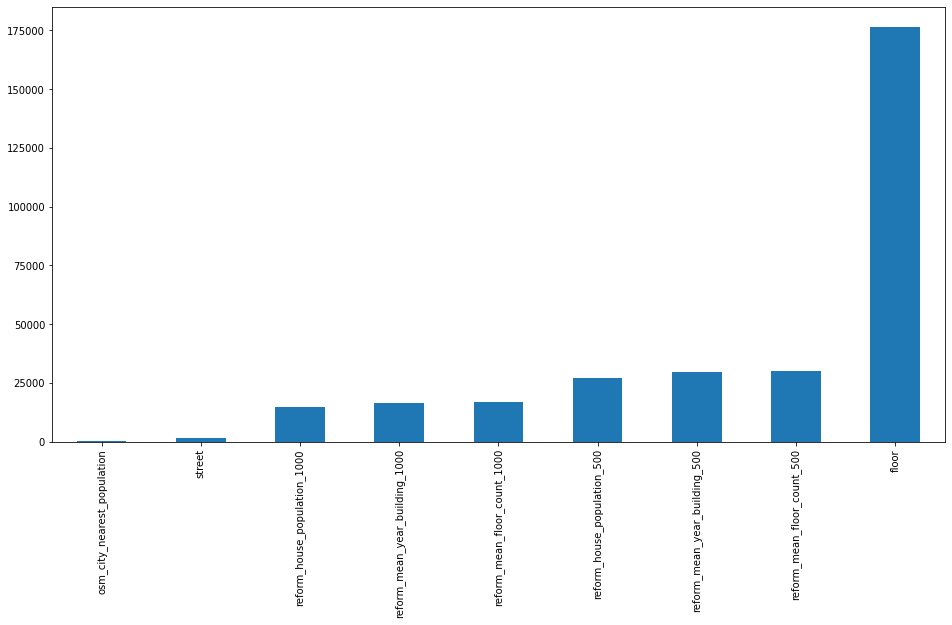

In [97]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()


### Features with null values (test)

<AxesSubplot:>

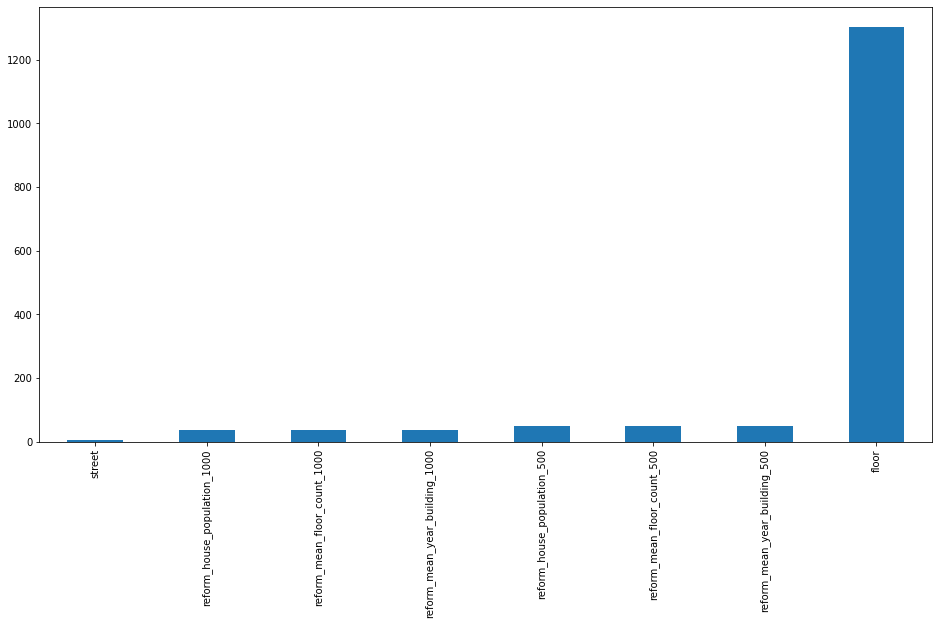

In [98]:
missing = test.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [24]:
tmp = test.isnull().sum()
print('---------------- Test Dataset ----------------------')
print(tmp[tmp > 0])
print('----------------------------------------------------')
tmp1 = train.isnull().sum()
print('---------------- Train Dataset ----------------------')
print(tmp1[tmp1 > 0])
print('-----------------------------------------------------')

---------------- Test Dataset ----------------------
floor                             1301
reform_house_population_1000        35
reform_house_population_500         48
reform_mean_floor_count_1000        35
reform_mean_floor_count_500         48
reform_mean_year_building_1000      35
reform_mean_year_building_500       48
street                               6
dtype: int64
----------------------------------------------------
---------------- Train Dataset ----------------------
floor                             176237
osm_city_nearest_population           55
reform_house_population_1000       14596
reform_house_population_500        27234
reform_mean_floor_count_1000       16708
reform_mean_floor_count_500        30168
reform_mean_year_building_1000     16239
reform_mean_year_building_500      29637
street                              1606
dtype: int64
-----------------------------------------------------


### Рсапределение цены

In [ ]:
import scipy.stats as st
y = train[TV]
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

### Тест фич на нормальность

In [100]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


False


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

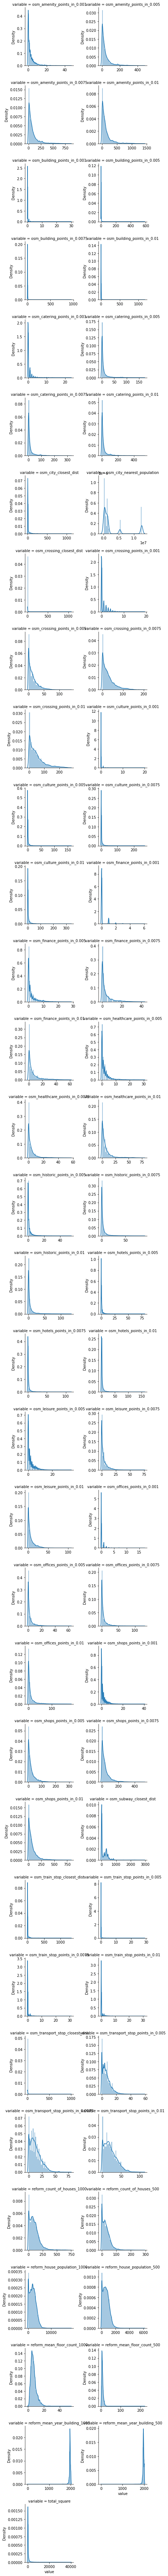

In [101]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

### Анализ категорий

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 39286 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 27827 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 21439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 32485 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 33452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24066 missing from c

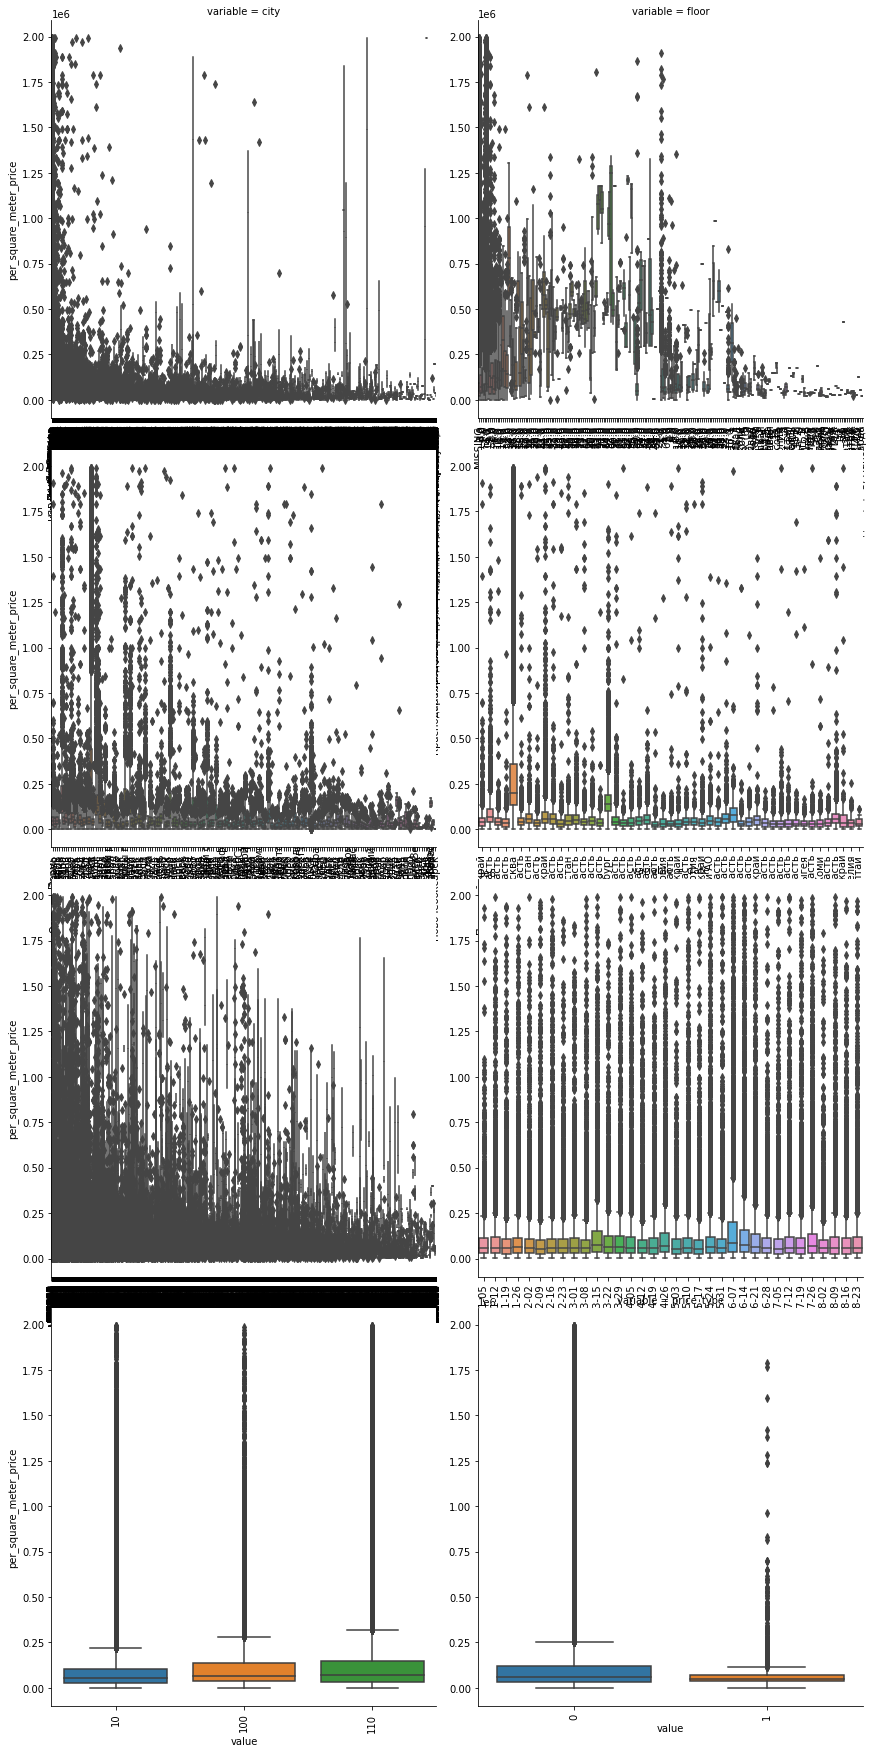

In [105]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=[TV], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=6)
g = g.map(boxplot, "value", TV)

### Важность фич (влияние на цену поодиночке)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


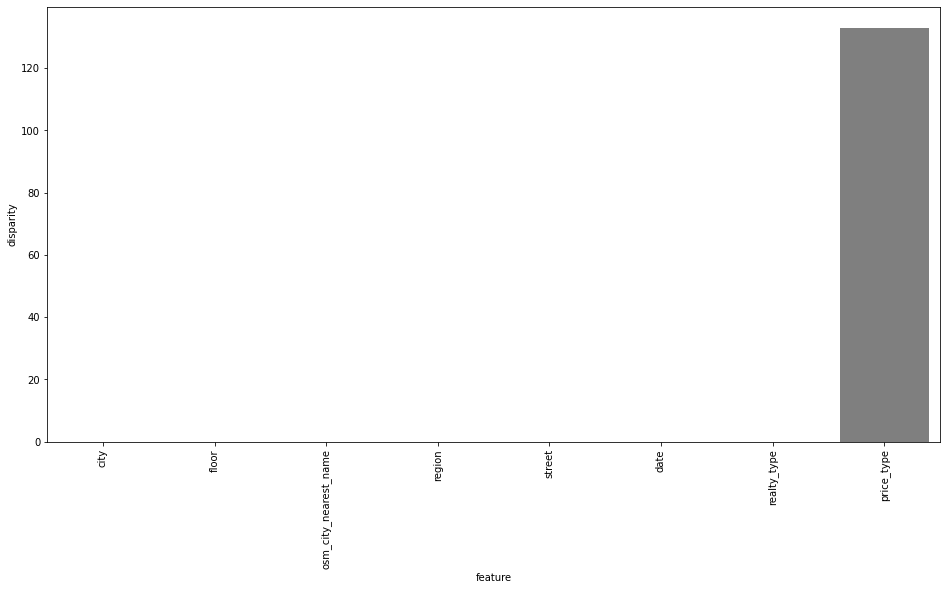

In [107]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls][TV].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. 

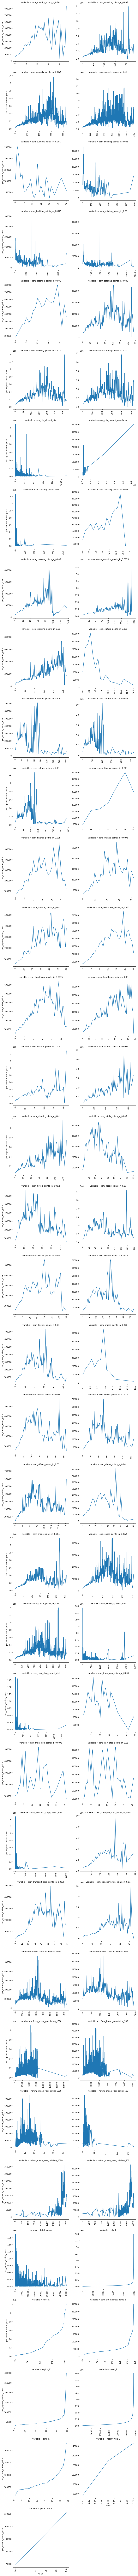

In [112]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=[TV], value_vars=quantitative + qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", TV)

### Корреляции

['city_E', 'floor_E', 'osm_city_nearest_name_E', 'region_E', 'street_E', 'date_E', 'realty_type_E', 'price_type_E']


<AxesSubplot:>

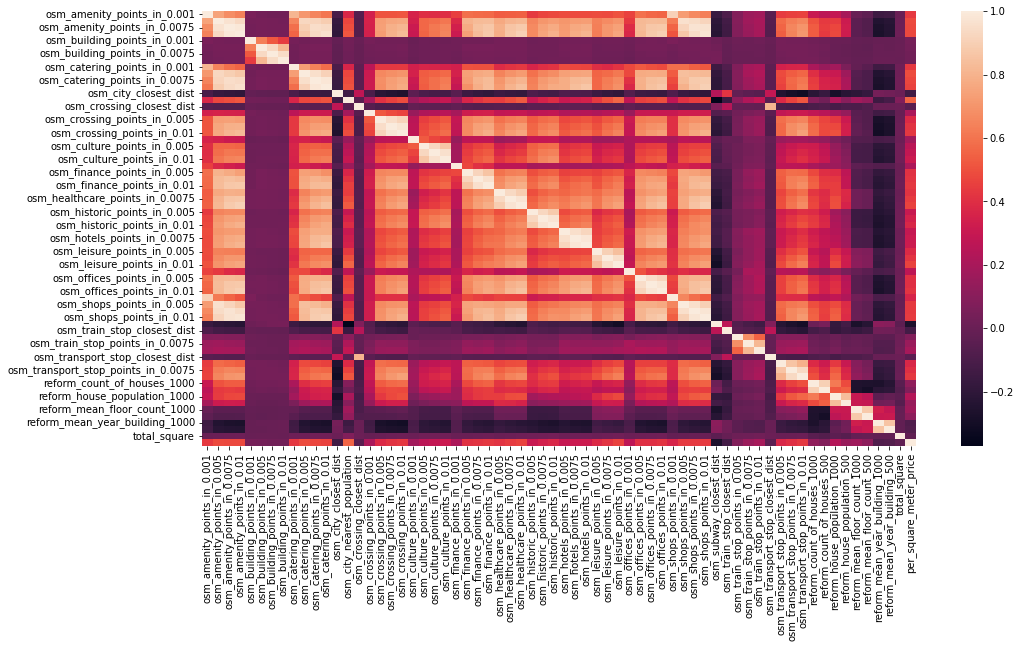

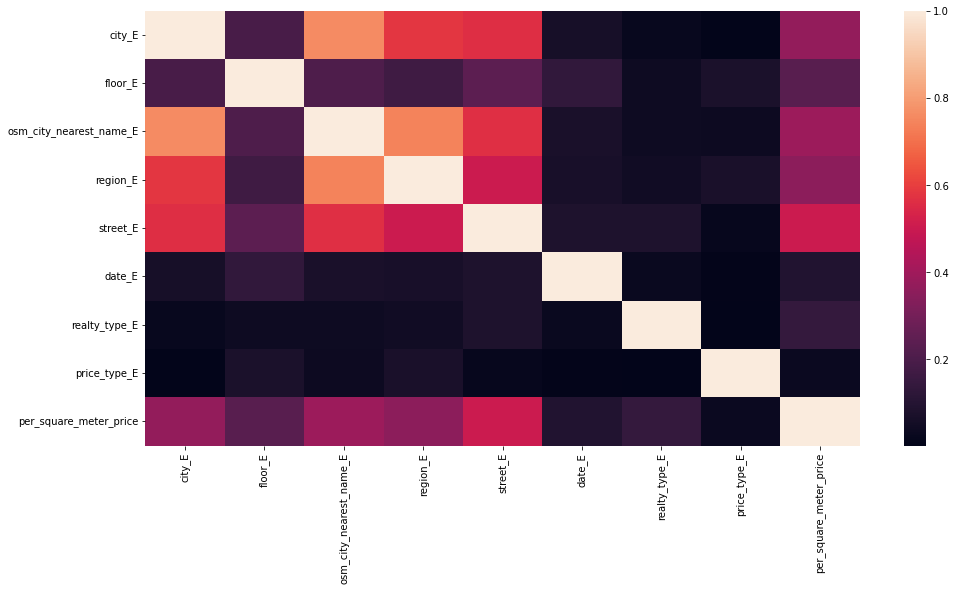

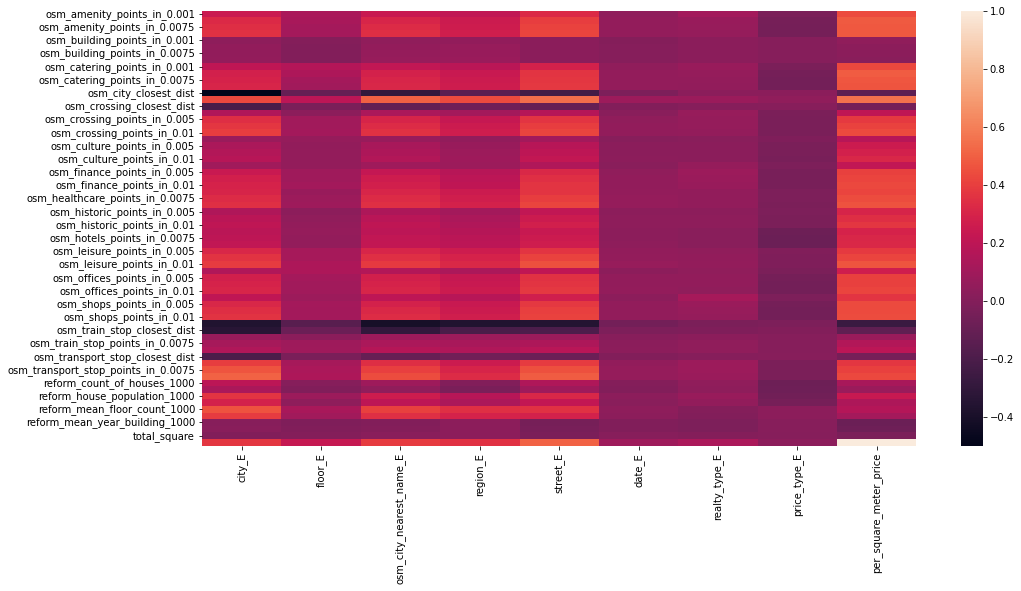

In [111]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, TV]].groupby(feature).mean()[TV]
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

plt.figure(1)
corr = train[quantitative+[TV]].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+[TV]].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+[TV], columns=qual_encoded+[TV])
for q1 in quantitative+[TV]:
    for q2 in qual_encoded+[TV]:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

### Анализ ценовых сегментов

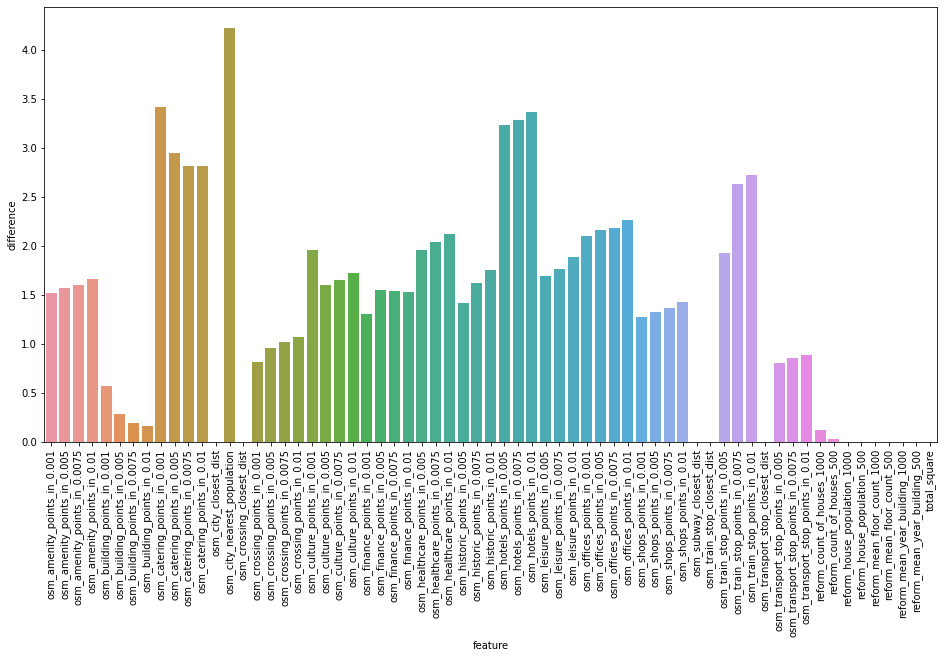

In [113]:
features = quantitative

standard = train[train[TV] < 100000]
pricey = train[train[TV] >= 100000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

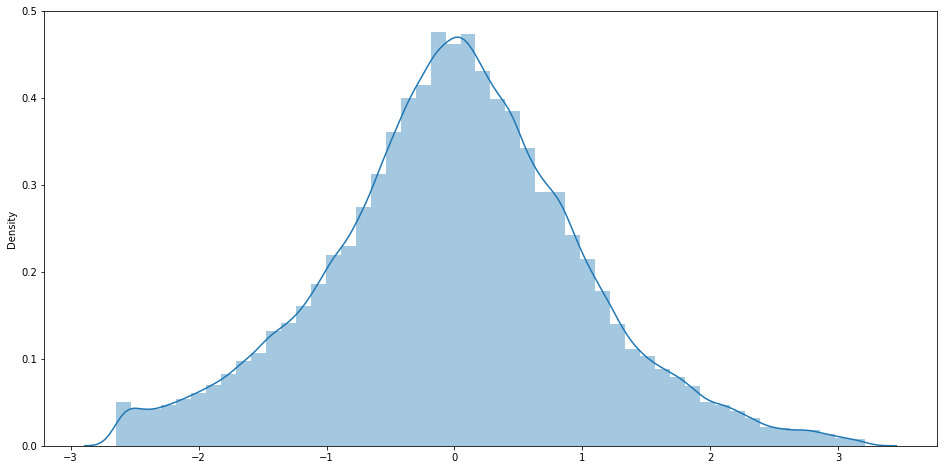

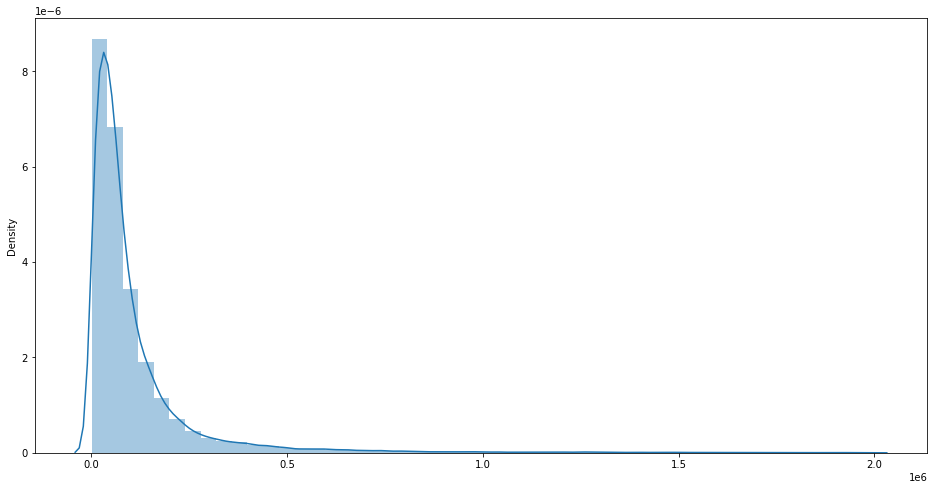

In [115]:
y = train[TV].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

### Проверка некоторых фич

In [120]:
new = train.copy()

new["ppl_500"] =  new['reform_house_population_500'] / (np.pi * 25000)
new["ppl_1000"] =  new['reform_house_population_1000'] / (np.pi * 100000)
new["house_500"] = new['reform_count_of_houses_500'] / (np.pi * 25000)
new["house_1000"] = new['reform_count_of_houses_1000'] / (np.pi * 100000)

new